RECOMMENDATION SYSTEM

Step 1: Install requirements

In [ ]:
!pip install pandas scikit-surprise matplotlib seaborn



Step 2: Download and Load the datasets

In [ ]:
import pandas as pd
import zipfile
import urllib.request

# Download the dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
urllib.request.urlretrieve(url, 'ml-20m.zip')

# Unzip the dataset
with zipfile.ZipFile('ml-20m.zip', 'r') as zip_ref:
    zip_ref.extractall('ml-20m')

# Load the data into pandas DataFrames
ratings = pd.read_csv('ml-20m/ratings.csv')
movies = pd.read_csv('ml-20m/movies.csv')

# Merge the two DataFrames to get movie titles with ratings
movie_ratings = pd.merge(ratings, movies[['movieId', 'title', 'genres']], on='movieId')

# Display the first few rows of the merged dataframe
print(movie_ratings.head())



   userId  movieId  rating   timestamp           title  \
0       1        2     3.5  1112486027  Jumanji (1995)   
1       5        2     3.0   851527569  Jumanji (1995)   
2      13        2     3.0   849082742  Jumanji (1995)   
3      29        2     3.0   835562174  Jumanji (1995)   
4      34        2     3.0   846509384  Jumanji (1995)   

                       genres  
0  Adventure|Children|Fantasy  
1  Adventure|Children|Fantasy  
2  Adventure|Children|Fantasy  
3  Adventure|Children|Fantasy  
4  Adventure|Children|Fantasy  


Step 3: Data Preprocessing

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['timestamp', 'genres']
movie_ratings = movie_ratings.drop(columns_to_drop, axis=1)

# Display number of unique users and movies
n_users = movie_ratings['userId'].nunique()
n_movies = movie_ratings['movieId'].nunique()

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')




Number of unique users: 138493
Number of unique movies: 26744


Step 4: Building Recommender System

In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import CoClustering
from surprise import accuracy

# Load the dataset into Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Use CoClustering for collaborative filtering
algo = CoClustering()
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Compute and print RMSE
accuracy.rmse(predictions)


RMSE: 0.8768


0.8767696117537269

Step 5: Making Movie Recommendations

In [ ]:
def get_movie_recommendations(user_id, n_recommendations=10):
    # Get a list of all movie ids
    movie_ids = movie_ratings['movieId'].unique()

    # Get the list of movies the user has already rated
    user_rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId']

    # Get a list of unrated movies
    unrated_movies = [movie for movie in movie_ids if movie not in user_rated_movies]

    # Predict ratings for unrated movies
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort predictions by estimated rating in descending order
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Get top n recommendations
    top_recommendations = recommendations[:n_recommendations]

    # Get the movie titles for the top recommendations
    recommended_movie_ids = [rec.iid for rec in top_recommendations]
    recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()

    return recommended_movies

# Example: Get top 10 movie recommendations for a user
user_id = 1
recommendations = get_movie_recommendations(user_id, n_recommendations=10)
print(f'Top 10 movie recommendations for user_id {user_id}:')
print(recommendations)


Top 10 movie recommendations for user_id 1:
          movieId                                              title
19841116   114214                             Mishen (Target) (2011)
19938461    79866            Schmatta: Rags to Riches to Rags (2009)
19963165   109931                      Repentance (Monanieba) (1984)
19964222    92956                            Little Criminals (1995)
19973441   103411                  Doctor and the Devils, The (1985)
19974073   103871  Consuming Kids: The Commercialization of Child...
19979906    26459                      Scarlet Pimpernel, The (1982)
19983539    89133                               Boys (Drenge) (1977)
19984821   130996                         The Beautiful Story (1992)
19987325    31154                                  Heartlands (2002)


Step 6: To Generate some graphs to visualise data

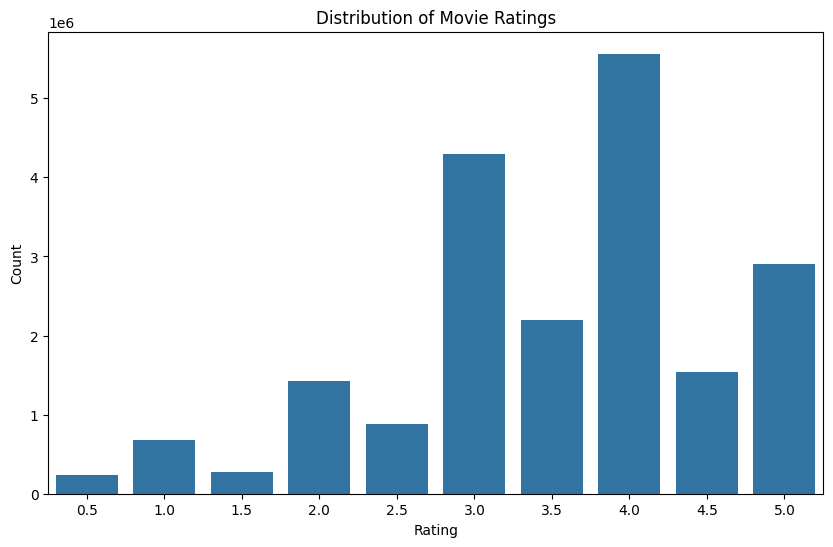

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=movie_ratings)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Visualization of Top-N Recommendations for a specific user

In [ ]:
def get_movie_recommendations(user_id, n_recommendations=10):
    movie_ids = movie_ratings['movieId'].unique()
    user_rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId']
    unrated_movies = [movie for movie in movie_ids if movie not in user_rated_movies]
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_recommendations = recommendations[:n_recommendations]
    recommended_movie_ids = [rec.iid for rec in top_recommendations]
    recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()
    recommended_movies['est_rating'] = [rec.est for rec in top_recommendations]
    return recommended_movies

# Get top 10 movie recommendations for a user
user_id = 1
recommendations = get_movie_recommendations(user_id, n_recommendations=10)
print("Top 10 movie recommendations for user_id:", user_id)
print(recommendations)

# Debug: Print the recommendations DataFrame
print(recommendations)



Top 10 movie recommendations for user_id: 1
          movieId                                              title  \
19841116   114214                             Mishen (Target) (2011)   
19938461    79866            Schmatta: Rags to Riches to Rags (2009)   
19963165   109931                      Repentance (Monanieba) (1984)   
19964222    92956                            Little Criminals (1995)   
19973441   103411                  Doctor and the Devils, The (1985)   
19974073   103871  Consuming Kids: The Commercialization of Child...   
19979906    26459                      Scarlet Pimpernel, The (1982)   
19983539    89133                               Boys (Drenge) (1977)   
19984821   130996                         The Beautiful Story (1992)   
19987325    31154                                  Heartlands (2002)   

          est_rating  
19841116           5  
19938461           5  
19963165           5  
19964222           5  
19973441           5  
19974073           5  
19

Visualization of Ratings Distribution

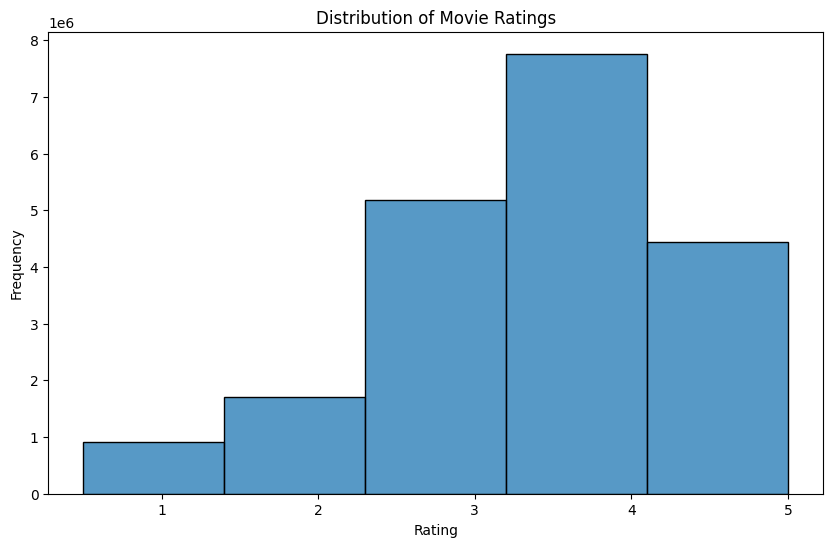

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings['rating'], bins=5, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

<ipython-input-10-cbd1b74a9d04>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='est_rating', y='title', data=recommendations, palette='viridis')


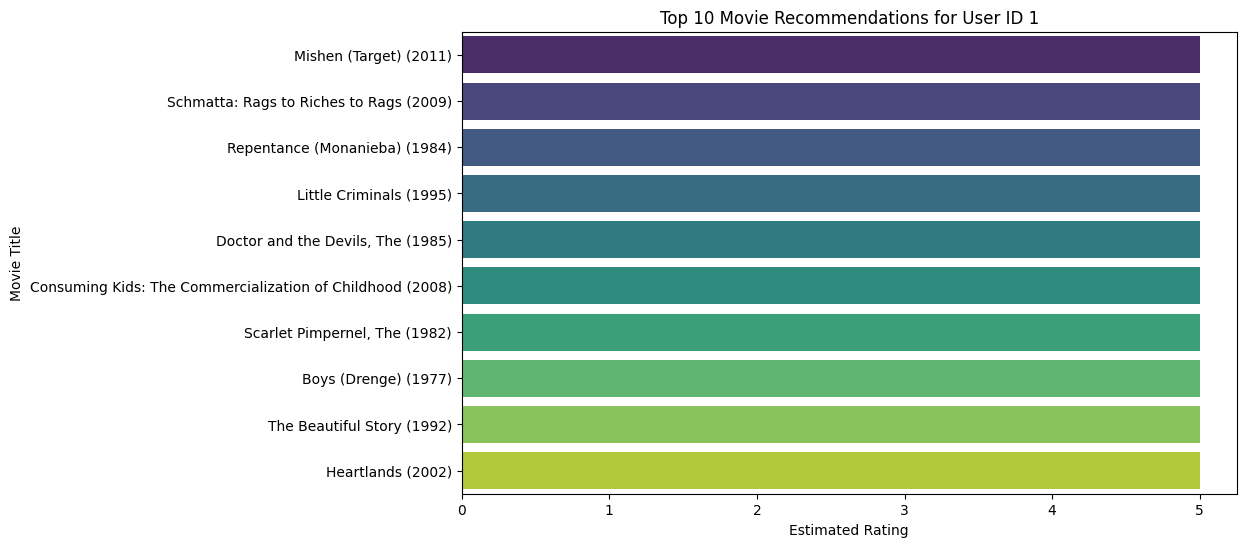

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting top 10 recommendations for the user
plt.figure(figsize=(10, 6))
sns.barplot(x='est_rating', y='title', data=recommendations, palette='viridis')
plt.title(f'Top 10 Movie Recommendations for User ID {user_id}')
plt.xlabel('Estimated Rating')
plt.ylabel('Movie Title')
plt.show()

Making Movie Recommendations

In [ ]:
# Define a function to train the model and collect RMSE at each epoch
def train_and_evaluate(data, n_epochs=20):
    kf = KFold(n_splits=5)
    rmse_per_epoch = []

    for epoch in range(1, n_epochs + 1):
        algo = CoClustering(n_epochs=epoch)
        rmse_for_epoch = []

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)
            rmse = accuracy.rmse(predictions, verbose=False)
            rmse_for_epoch.append(rmse)

        avg_rmse = sum(rmse_for_epoch) / len(rmse_for_epoch)
        rmse_per_epoch.append(avg_rmse)
        print(f'Epoch {epoch} Average RMSE: {avg_rmse:.4f}')

    return rmse_per_epoch



In [ ]:
# Example: Get top 10 recommendations for user_id 1
user_id = 1
recommendations = get_movie_recommendations(user_id, n_recommendations=10)
print("Top 10 movie recommendations for user_id:", user_id)
print(recommendations)


Top 10 movie recommendations for user_id: 1
          movieId                                              title  \
19841116   114214                             Mishen (Target) (2011)   
19938461    79866            Schmatta: Rags to Riches to Rags (2009)   
19963165   109931                      Repentance (Monanieba) (1984)   
19964222    92956                            Little Criminals (1995)   
19973441   103411                  Doctor and the Devils, The (1985)   
19974073   103871  Consuming Kids: The Commercialization of Child...   
19979906    26459                      Scarlet Pimpernel, The (1982)   
19983539    89133                               Boys (Drenge) (1977)   
19984821   130996                         The Beautiful Story (1992)   
19987325    31154                                  Heartlands (2002)   

          est_rating  
19841116           5  
19938461           5  
19963165           5  
19964222           5  
19973441           5  
19974073           5  
19